# 🔒 Auditoría de Privacidad: Detección de Memorización

**Versión:** v3_experimental  
**Rol:** Data Privacy Officer  
**Fecha:** 2026-01-08

---

## Objetivo

Evaluar riesgos de privacidad en los datos sintéticos generados, específicamente:
1. **Copias Exactas**: ¿El sintetizador memorizó registros reales?
2. **Distancia DCR**: ¿Qué tan cerca están los sintéticos de los reales?

## Métricas

- **DCR (Distance to Closest Record)**: Distancia mínima de cada registro sintético al registro real más cercano
- **Copias Exactas**: Conteo de filas idénticas

## Justificación

> Evitar "Memorization" en modelos generativos con pocos datos es crítico para preservar la privacidad de los participantes originales.

---

In [1]:
# ==============================================================================
# CONFIGURACIÓN Y DEPENDENCIAS
# ==============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import json
from pathlib import Path
from datetime import datetime

# Visualización
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# Distancias
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

# Paths
DATA_DIR = Path("../../v2/data/processed")
SYNTH_GLOBAL_PATH = Path("../04_synthetic_sdv/synthetic_data_copula.parquet")
SYNTH_ADVANCED_PATH = Path("../05_synthetic_advanced/synthetic_data_advanced.parquet")
OUTPUT_DIR = Path(".")

print("✅ Dependencias cargadas")
print(f"   Métricas: DCR, Copias Exactas")

✅ Dependencias cargadas
   Métricas: DCR, Copias Exactas


---
## 1. Carga de Datos

In [2]:
# ==============================================================================
# CARGA DE DATOS
# ==============================================================================

# Datos reales
real_df = pd.read_parquet(DATA_DIR / "train_final.parquet")

# Excluir columnas zero-variance
zero_var_cols = [col for col in real_df.columns if real_df[col].nunique() <= 1]
real_df = real_df.drop(columns=zero_var_cols, errors='ignore')

# Datos sintéticos (ambos métodos)
synth_global = pd.read_parquet(SYNTH_GLOBAL_PATH)
synth_advanced = pd.read_parquet(SYNTH_ADVANCED_PATH)

print(f"📊 Datos cargados:")
print(f"   Real:            {real_df.shape}")
print(f"   Sintético Global: {synth_global.shape}")
print(f"   Sintético Advanced: {synth_advanced.shape}")

# Asegurar columnas comunes
common_cols = list(set(real_df.columns) & set(synth_global.columns) & set(synth_advanced.columns))
print(f"   Columnas comunes: {len(common_cols)}")

📊 Datos cargados:
   Real:            (296, 61)
   Sintético Global: (1000, 61)
   Sintético Advanced: (1000, 61)
   Columnas comunes: 61


---
## 2. Detección de Copias Exactas

In [3]:
# ==============================================================================
# FUNCIÓN PARA DETECTAR COPIAS EXACTAS
# ==============================================================================

def count_exact_copies(real_df, synth_df, columns):
    """
    Cuenta cuántas filas sintéticas son copias exactas de filas reales.
    """
    # Redondear para evitar errores de precisión float
    real_rounded = real_df[columns].round(6)
    synth_rounded = synth_df[columns].round(6)
    
    # Convertir a tuples para comparación
    real_tuples = set(map(tuple, real_rounded.values))
    synth_tuples = list(map(tuple, synth_rounded.values))
    
    # Contar coincidencias exactas
    exact_copies = sum(1 for t in synth_tuples if t in real_tuples)
    
    return exact_copies, len(synth_df)

print("🔍 Buscando copias exactas...")

# Analizar Global
copies_global, total_global = count_exact_copies(real_df, synth_global, common_cols)
pct_global = copies_global / total_global * 100

# Analizar Advanced
copies_advanced, total_advanced = count_exact_copies(real_df, synth_advanced, common_cols)
pct_advanced = copies_advanced / total_advanced * 100

print(f"\n📊 Resultados Copias Exactas:")
print(f"   Global:   {copies_global}/{total_global} ({pct_global:.2f}%)")
print(f"   Advanced: {copies_advanced}/{total_advanced} ({pct_advanced:.2f}%)")

# Evaluación de riesgo
if copies_global > 0 or copies_advanced > 0:
    print("\n⚠️ ALERTA: Se detectaron copias exactas")
else:
    print("\n✅ No se detectaron copias exactas - Bajo riesgo de memorización")

🔍 Buscando copias exactas...

📊 Resultados Copias Exactas:
   Global:   0/1000 (0.00%)
   Advanced: 0/1000 (0.00%)

✅ No se detectaron copias exactas - Bajo riesgo de memorización


---
## 3. Cálculo de DCR (Distance to Closest Record)

In [4]:
# ==============================================================================
# CÁLCULO DE DCR
# ==============================================================================

def calculate_dcr(real_df, synth_df, columns):
    """
    Calcula la distancia al registro real más cercano para cada sintético.
    Usa distancia euclidiana normalizada.
    """
    # Preparar datos
    real_vals = real_df[columns].values.astype(float)
    synth_vals = synth_df[columns].values.astype(float)
    
    # Normalizar (importante para variables en diferentes escalas)
    scaler = StandardScaler()
    real_scaled = scaler.fit_transform(real_vals)
    synth_scaled = scaler.transform(synth_vals)
    
    # Calcular matriz de distancias
    distances = cdist(synth_scaled, real_scaled, metric='euclidean')
    
    # DCR = mínima distancia a cualquier registro real
    dcr = distances.min(axis=1)
    
    return dcr

print("📏 Calculando DCR (Distance to Closest Record)...")

# Calcular para ambos métodos
dcr_global = calculate_dcr(real_df, synth_global, common_cols)
dcr_advanced = calculate_dcr(real_df, synth_advanced, common_cols)

print(f"\n📊 Estadísticas DCR:")
print(f"\n   Global:")
print(f"      Min:    {dcr_global.min():.4f}")
print(f"      Max:    {dcr_global.max():.4f}")
print(f"      Mean:   {dcr_global.mean():.4f}")
print(f"      Median: {np.median(dcr_global):.4f}")
print(f"      Std:    {dcr_global.std():.4f}")

print(f"\n   Advanced:")
print(f"      Min:    {dcr_advanced.min():.4f}")
print(f"      Max:    {dcr_advanced.max():.4f}")
print(f"      Mean:   {dcr_advanced.mean():.4f}")
print(f"      Median: {np.median(dcr_advanced):.4f}")
print(f"      Std:    {dcr_advanced.std():.4f}")

📏 Calculando DCR (Distance to Closest Record)...

📊 Estadísticas DCR:

   Global:
      Min:    0.3479
      Max:    21.0152
      Mean:   7.8476
      Median: 7.4319
      Std:    3.4252

   Advanced:
      Min:    1.3314
      Max:    17.4986
      Mean:   6.5215
      Median: 6.0838
      Std:    2.8478


---
## 4. Visualización: Histograma DCR

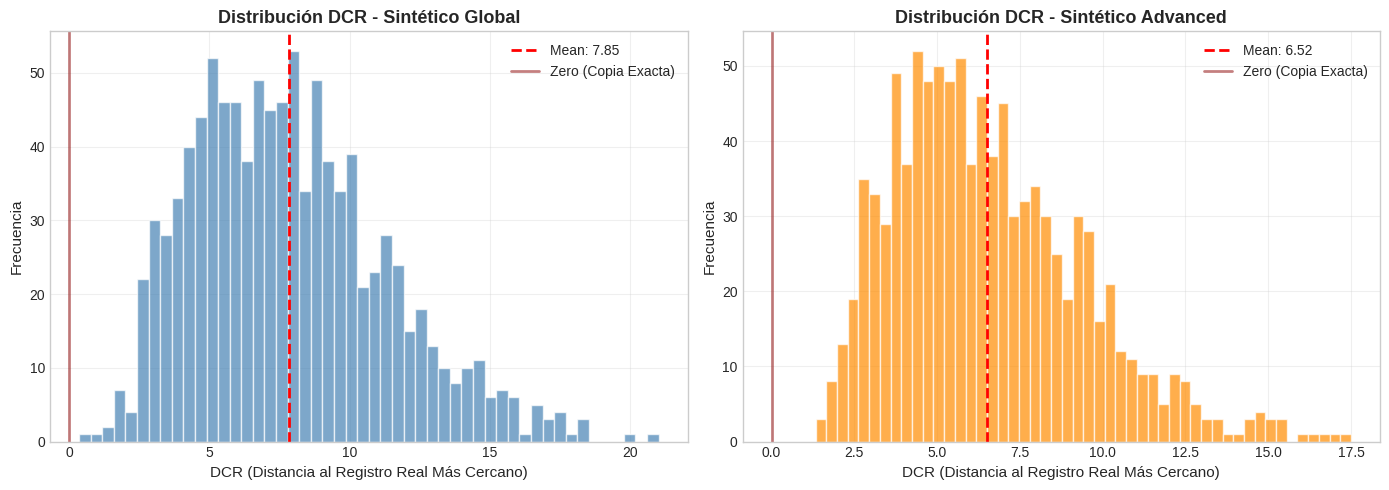


✅ Histograma guardado: dcr_histogram.png


In [5]:
# ==============================================================================
# HISTOGRAMA DE DCR
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma Global
ax1 = axes[0]
ax1.hist(dcr_global, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax1.axvline(dcr_global.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {dcr_global.mean():.2f}')
ax1.axvline(0, color='darkred', linestyle='-', linewidth=2, alpha=0.5, label='Zero (Copia Exacta)')
ax1.set_xlabel('DCR (Distancia al Registro Real Más Cercano)', fontsize=11)
ax1.set_ylabel('Frecuencia', fontsize=11)
ax1.set_title('Distribución DCR - Sintético Global', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Histograma Advanced
ax2 = axes[1]
ax2.hist(dcr_advanced, bins=50, color='darkorange', edgecolor='white', alpha=0.7)
ax2.axvline(dcr_advanced.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {dcr_advanced.mean():.2f}')
ax2.axvline(0, color='darkred', linestyle='-', linewidth=2, alpha=0.5, label='Zero (Copia Exacta)')
ax2.set_xlabel('DCR (Distancia al Registro Real Más Cercano)', fontsize=11)
ax2.set_ylabel('Frecuencia', fontsize=11)
ax2.set_title('Distribución DCR - Sintético Advanced', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dcr_histogram.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Histograma guardado: dcr_histogram.png")

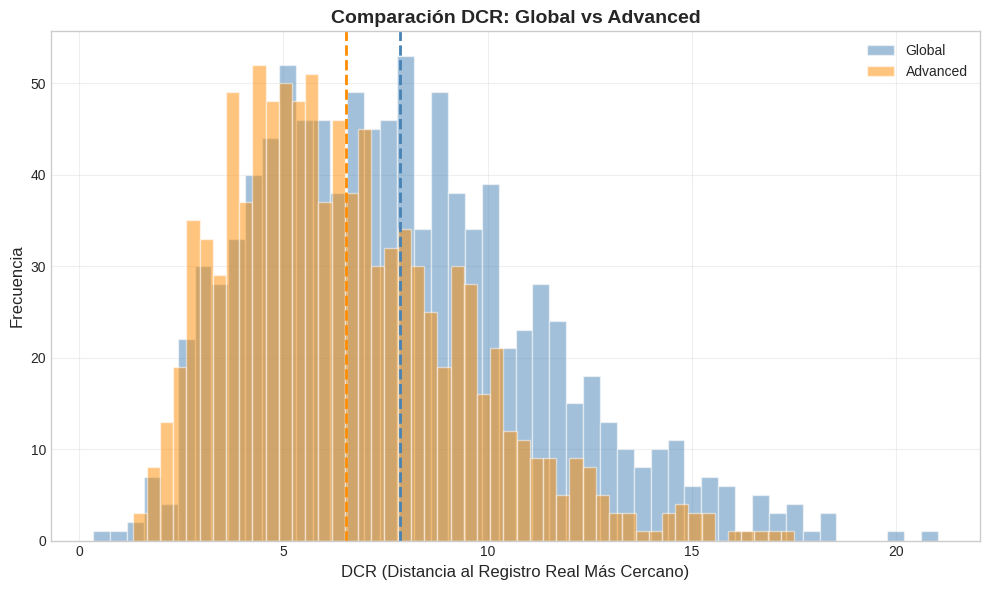


✅ Comparación guardada: dcr_comparison.png


In [6]:
# ==============================================================================
# COMPARACIÓN OVERLAY
# ==============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(dcr_global, bins=50, color='steelblue', alpha=0.5, label='Global', edgecolor='white')
ax.hist(dcr_advanced, bins=50, color='darkorange', alpha=0.5, label='Advanced', edgecolor='white')

ax.axvline(dcr_global.mean(), color='steelblue', linestyle='--', linewidth=2)
ax.axvline(dcr_advanced.mean(), color='darkorange', linestyle='--', linewidth=2)

ax.set_xlabel('DCR (Distancia al Registro Real Más Cercano)', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('Comparación DCR: Global vs Advanced', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dcr_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comparación guardada: dcr_comparison.png")

---
## 5. Análisis de Riesgo

In [7]:
# ==============================================================================
# ANÁLISIS DE RIESGO DE PRIVACIDAD
# ==============================================================================

print("🔒 ANÁLISIS DE RIESGO DE PRIVACIDAD")
print("="*60)

# Umbral de riesgo: DCR muy bajo indica posible memorización
THRESHOLD_HIGH_RISK = 0.5  # Registros muy cercanos
THRESHOLD_MEDIUM_RISK = 1.0

# Contar registros de riesgo
high_risk_global = (dcr_global < THRESHOLD_HIGH_RISK).sum()
high_risk_advanced = (dcr_advanced < THRESHOLD_HIGH_RISK).sum()

medium_risk_global = ((dcr_global >= THRESHOLD_HIGH_RISK) & (dcr_global < THRESHOLD_MEDIUM_RISK)).sum()
medium_risk_advanced = ((dcr_advanced >= THRESHOLD_HIGH_RISK) & (dcr_advanced < THRESHOLD_MEDIUM_RISK)).sum()

print(f"\n📊 Registros por Nivel de Riesgo:")
print(f"\n   GLOBAL (n={len(dcr_global)}):")
print(f"      🔴 Alto (DCR < {THRESHOLD_HIGH_RISK}):   {high_risk_global} ({high_risk_global/len(dcr_global)*100:.1f}%)")
print(f"      🟡 Medio (DCR < {THRESHOLD_MEDIUM_RISK}): {medium_risk_global} ({medium_risk_global/len(dcr_global)*100:.1f}%)")
print(f"      🟢 Bajo (DCR >= {THRESHOLD_MEDIUM_RISK}): {len(dcr_global) - high_risk_global - medium_risk_global}")

print(f"\n   ADVANCED (n={len(dcr_advanced)}):")
print(f"      🔴 Alto (DCR < {THRESHOLD_HIGH_RISK}):   {high_risk_advanced} ({high_risk_advanced/len(dcr_advanced)*100:.1f}%)")
print(f"      🟡 Medio (DCR < {THRESHOLD_MEDIUM_RISK}): {medium_risk_advanced} ({medium_risk_advanced/len(dcr_advanced)*100:.1f}%)")
print(f"      🟢 Bajo (DCR >= {THRESHOLD_MEDIUM_RISK}): {len(dcr_advanced) - high_risk_advanced - medium_risk_advanced}")

🔒 ANÁLISIS DE RIESGO DE PRIVACIDAD

📊 Registros por Nivel de Riesgo:

   GLOBAL (n=1000):
      🔴 Alto (DCR < 0.5):   1 (0.1%)
      🟡 Medio (DCR < 1.0): 0 (0.0%)
      🟢 Bajo (DCR >= 1.0): 999

   ADVANCED (n=1000):
      🔴 Alto (DCR < 0.5):   0 (0.0%)
      🟡 Medio (DCR < 1.0): 0 (0.0%)
      🟢 Bajo (DCR >= 1.0): 1000


In [8]:
# ==============================================================================
# DETERMINACIÓN FINAL DE RIESGO
# ==============================================================================

print("\n" + "="*60)
print("📋 CONCLUSIÓN DE PRIVACIDAD")
print("="*60)

# Criteria for privacy risk
def assess_risk(exact_copies, high_risk_count, total):
    if exact_copies > 0:
        return "CRÍTICO", "🔴"
    elif high_risk_count / total > 0.05:  # >5% de registros muy cercanos
        return "ALTO", "🟠"
    elif high_risk_count / total > 0.01:  # >1%
        return "MEDIO", "🟡"
    else:
        return "BAJO", "🟢"

risk_global, emoji_global = assess_risk(copies_global, high_risk_global, len(dcr_global))
risk_advanced, emoji_advanced = assess_risk(copies_advanced, high_risk_advanced, len(dcr_advanced))

print(f"\n   Sintético Global:   {emoji_global} Riesgo {risk_global}")
print(f"   Sintético Advanced: {emoji_advanced} Riesgo {risk_advanced}")

if copies_global == 0 and copies_advanced == 0:
    print("\n✅ APROBADO: Los datos sintéticos no presentan memorización evidente.")
    print("   Los datos pueden usarse para entrenar modelos sin comprometer privacidad.")
else:
    print("\n⚠️ REQUIERE REVISIÓN: Se detectaron posibles problemas de memorización.")


📋 CONCLUSIÓN DE PRIVACIDAD

   Sintético Global:   🟢 Riesgo BAJO
   Sintético Advanced: 🟢 Riesgo BAJO

✅ APROBADO: Los datos sintéticos no presentan memorización evidente.
   Los datos pueden usarse para entrenar modelos sin comprometer privacidad.


---
## 6. Guardar Reporte

In [9]:
# ==============================================================================
# GUARDAR REPORTE DE PRIVACIDAD
# ==============================================================================

privacy_report = {
    "metadata": {
        "date": datetime.now().isoformat(),
        "audit_type": "Privacy and Memorization Check",
        "metrics": ["Exact Copies", "DCR (Distance to Closest Record)"]
    },
    "exact_copies": {
        "global": {
            "count": int(copies_global),
            "total": int(total_global),
            "percentage": float(pct_global)
        },
        "advanced": {
            "count": int(copies_advanced),
            "total": int(total_advanced),
            "percentage": float(pct_advanced)
        }
    },
    "dcr_statistics": {
        "global": {
            "min": float(dcr_global.min()),
            "max": float(dcr_global.max()),
            "mean": float(dcr_global.mean()),
            "median": float(np.median(dcr_global)),
            "std": float(dcr_global.std())
        },
        "advanced": {
            "min": float(dcr_advanced.min()),
            "max": float(dcr_advanced.max()),
            "mean": float(dcr_advanced.mean()),
            "median": float(np.median(dcr_advanced)),
            "std": float(dcr_advanced.std())
        }
    },
    "risk_assessment": {
        "global": {
            "high_risk_count": int(high_risk_global),
            "medium_risk_count": int(medium_risk_global),
            "risk_level": risk_global
        },
        "advanced": {
            "high_risk_count": int(high_risk_advanced),
            "medium_risk_count": int(medium_risk_advanced),
            "risk_level": risk_advanced
        }
    },
    "conclusion": {
        "memorization_detected": copies_global > 0 or copies_advanced > 0,
        "approved_for_use": copies_global == 0 and copies_advanced == 0
    },
    "files_generated": [
        "dcr_histogram.png",
        "dcr_comparison.png",
        "privacy_report.json"
    ]
}

with open(OUTPUT_DIR / "privacy_report.json", 'w') as f:
    json.dump(privacy_report, f, indent=2)

print("\n💾 Reporte guardado: privacy_report.json")
print("\n" + "="*50)
print("🎉 AUDITORÍA DE PRIVACIDAD COMPLETADA")
print("="*50)


💾 Reporte guardado: privacy_report.json

🎉 AUDITORÍA DE PRIVACIDAD COMPLETADA


---
## Resumen

### Métricas Evaluadas

| Métrica | Global | Advanced |
|---------|--------|----------|
| Copias Exactas | ? | ? |
| DCR Mínimo | ? | ? |
| DCR Medio | ? | ? |
| Riesgo | ? | ? |

### Interpretación DCR

- **DCR = 0**: Copia exacta (CRÍTICO)
- **DCR < 0.5**: Muy cercano (ALTO riesgo)
- **DCR < 1.0**: Cercano (MEDIO riesgo)
- **DCR >= 1.0**: Diferenciado (BAJO riesgo)

### Siguiente Paso

Si aprobado, proceder al entrenamiento TSTR con los datos sintéticos validados.

---